In [1]:
# GSE279781_GeneCorr_Clusters_v01
# Alberto Bejarano (2024)
import time; start = time.time()
from datetime import datetime; print(datetime.now().strftime("%B %d, %Y %H:%M:%S"))

January 03, 2025 22:23:17


In [2]:
import warnings; warnings.filterwarnings("ignore") 
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
import pandas as pd;
pd.options.display.float_format = ' {:.3f}' .format
pd.options.display.max_columns = 200
pd.options.display.precision   = 2
pd.set_option.precision        = 2
#         .         .         .         .         .         .         .         .
import warnings; warnings.filterwarnings("ignore")
from matplotlib.pyplot import rc_context
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import matplotlib.transforms
import autograd.numpy as np
import matplotlib.cm as cm
from scipy import stats
import anndata as ad
import seaborn as sns
import scipy.io as sio
import scanpy as sc
import scipy
import os
sns.__version__

'0.13.2'

In [4]:
genes_to_highlight = ['HLA-DRB1', 'SRGN', 'TFF1']  # Replace with your list of genes

In [5]:
# HLA-DRB1   SRGN    TFF1     IFI30  COL1A1  CCL5    HSPA1A  MT-ND6   KRT8     STMN1    GZMB  NKG7    GNLY  JCHAIN    IL1B  IGFBP7     IL32  TPSAB1  CLDN3

In [6]:
# Assuming `adata` is your AnnData object and `cluster_key` is the key for cluster labels
resolution = 'leiden_0.50'  # Update with the actual column in `adata.obs` for cluster labels
cluster_1  = '0'  # Replace with your first cluster name/ID
cluster_2  = '2'  # Replace with your second cluster name/ID

In [7]:
path = '../../data/GSE279781/GSE279781_pcHVG.h5ad'
pcHVG_data = ad.read(path); print(pcHVG_data)

AnnData object with n_obs × n_vars = 5781 × 1460
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ri', 'pct_counts_ri', 'total_counts_hb', 'pct_counts_hb', 'outlier_ngenes', 'outlier_total', 'outlier_hb', 'outlier_mt', 'outlier_ri', 'leiden_0.10', 'leiden_0.25', 'leiden_0.50', 'leiden_0.75', 'leiden_1.00', 'leiden_1.25', 'leiden_1.50', 'leiden_2.00'
    var: 'ensembl_id', 'gene_catg', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt', 'ri', 'hb', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'dendrogram_leiden_0.75', 'hvg', 'leiden_0.10', 'leiden_0.10_colors', 'leiden_0.25', 'leiden_0.25_colors', 'leiden_0.50', 'leiden_0.50_colors', 'leiden_0.75', 'leiden_0.75_colors', 'leiden_1.00', 'leiden_1.00_colors', 'leiden_1.25', 'leiden_1.25_colors', 'leiden_1.50', 'leiden_1.50_colors', 'leiden_2.00', 'leiden_2.00_colors', 'log1p', 'logreg', 'neighbors', '

In [8]:
# Downsample the observations (cells)
print("Remaining cells:\t {}".format(pcHVG_data.n_obs))
num_cells_to_sample = int(0.05 * pcHVG_data.n_obs)
# Randomly select the indices of the cells to keep
random_indices = np.random.choice(pcHVG_data.obs_names, size=num_cells_to_sample, replace=False)
#pcHVG_data = pcHVG_data[random_indices, :]   # Subset the AnnData object based on the selected indices
# Check the shape of the downsampled data
print("Remaining cells:\t {}".format(pcHVG_data.n_obs), '\n')

Remaining cells:	 5781
Remaining cells:	 5781 



In [9]:
# Subset the data for each cluster
cluster_1_cells = pcHVG_data[pcHVG_data.obs[resolution] == cluster_1]
cluster_2_cells = pcHVG_data[pcHVG_data.obs[resolution] == cluster_2]

In [10]:
# Calculate average expression for each gene in each cluster
cluster_1_avg = np.asarray(cluster_1_cells.X.mean(axis=0)).flatten()
cluster_2_avg = np.asarray(cluster_2_cells.X.mean(axis=0)).flatten()

In [11]:
# Create a DataFrame for better visualization
correlation_df = pd.DataFrame({'Cluster_1_Avg_Expr': cluster_1_avg, 'Cluster_2_Avg_Expr': cluster_2_avg})

In [12]:
# Compute correlation
correlation = correlation_df.corr(method='pearson')  # Use 'spearman' if preferred

In [13]:
print("Correlation Matrix:")
print(correlation)

Correlation Matrix:
                    Cluster_1_Avg_Expr  Cluster_2_Avg_Expr
Cluster_1_Avg_Expr               1.000              -0.487
Cluster_2_Avg_Expr              -0.487               1.000


In [14]:
x = correlation_df['Cluster_1_Avg_Expr']
y = correlation_df['Cluster_2_Avg_Expr']

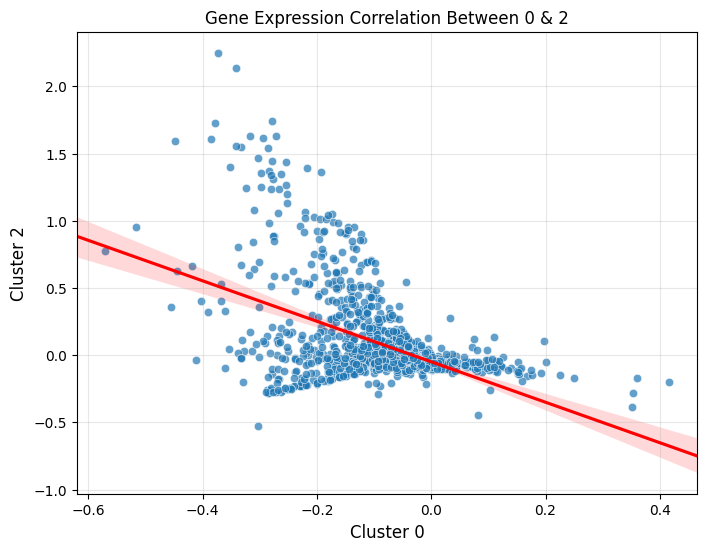

In [15]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, alpha=0.7)

# Add a line of best fit
sns.regplot(x=x, y=y, scatter=False, color='red', ci=95, truncate=False)

# Customize the plot
plt.title(f'Gene Expression Correlation Between {cluster_1} & {cluster_2}', fontsize=12)
plt.xlabel(f'Cluster {cluster_1}', fontsize=12)
plt.ylabel(f'Cluster {cluster_2}', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [16]:
# Get all unique clusters excluding Cluster 1
clusters = pcHVG_data.obs[resolution].unique()
clusters = [cluster for cluster in clusters if cluster != cluster_1]

# Set up the grid for subplots
n_cols = 3  # Number of columns in the grid
n_rows = int(np.ceil(len(clusters) / n_cols))  # Calculate rows based on number of clusters

In [23]:
# Use a colormap to dynamically generate colors
cmap = cm.get_cmap('tab20')  # Choose a colormap, e.g., 'tab10', 'viridis', 'plasma'
colors = [cmap(i / len(genes_to_highlight)) for i in range(len(genes_to_highlight))]  # Get distinct colors
print(colors)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0), (0.9686274509803922, 0.7137254901960784, 0.8235294117647058, 1.0)]


In [24]:
gene_indices = [pcHVG_data.var.index.get_loc(gene) for gene in genes_to_highlight]  # Get the indices of the genes

In [34]:
scatter_kws = {'s':50, 'alpha':0.9, 'linewidth':0.2, 'color':'#f2f2f2', 'edgecolor':'#1E1E1E'}

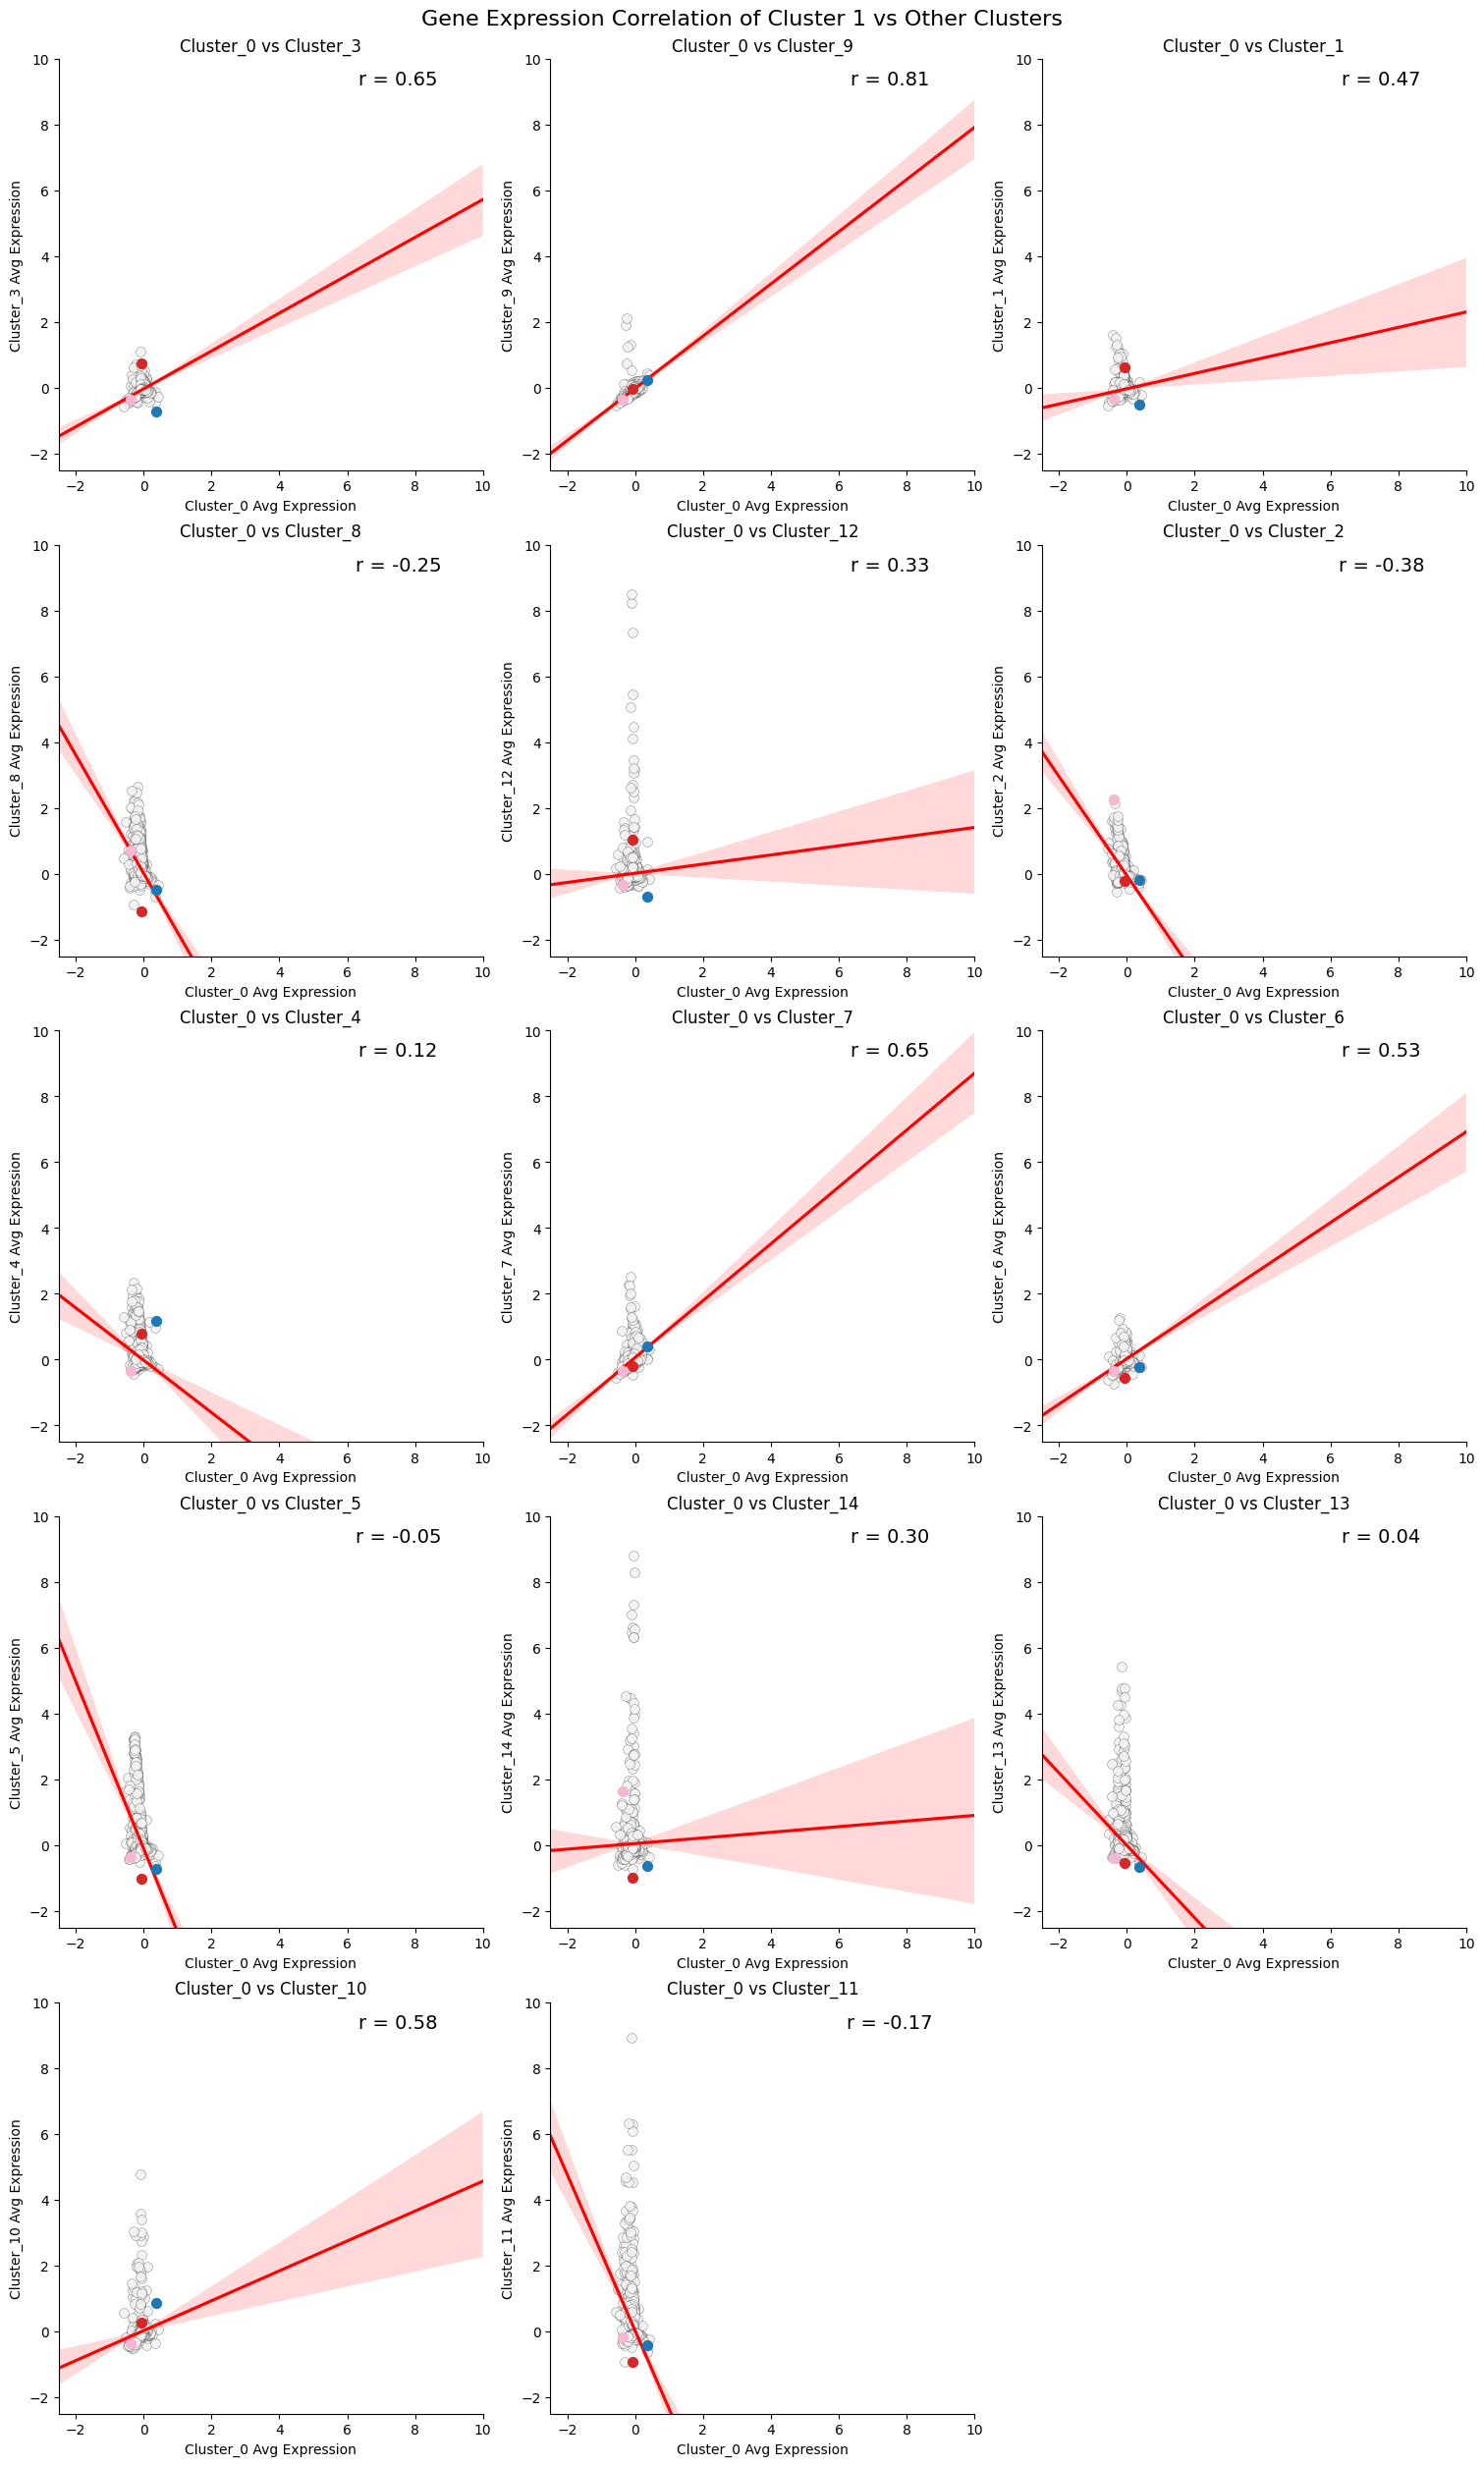

In [35]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), constrained_layout=True)

axes = axes.flatten()
#         .         .         .         .         .         .         .         .         .         .         .         .
for i, cluster in enumerate(clusters):
    cluster_1_cells       = pcHVG_data[pcHVG_data.obs[resolution] == cluster_1]
    current_cluster_cells = pcHVG_data[pcHVG_data.obs[resolution] == cluster]
#         .         .         .         .         .         .         .         .         .         .         .         .
    cluster_1_avg = np.asarray(cluster_1_cells.X.mean(axis=0)).flatten()
    current_cluster_avg = np.asarray(current_cluster_cells.X.mean(axis=0)).flatten()
#         .         .         .         .         .         .         .         .         .         .         .         .
    r, _ = spearmanr(cluster_1_avg, current_cluster_avg)
    axes[i].set_ylim([-2.5, 10]); axes[i].set_xlim([-2.5, 10]); sns.despine(ax=axes[i], right=True, top=True)
    sns.scatterplot(x=cluster_1_avg, y=current_cluster_avg, ax=axes[i], **scatter_kws)
    sns.regplot(x=cluster_1_avg, y=current_cluster_avg, scatter=False, color='red', ci=95, truncate=False, ax=axes[i])    
#         .         .         .         .         .         .         .         .         .         .         .         .
    for j, gene_index in enumerate(gene_indices):
        axes[i].scatter(cluster_1_avg[gene_index], current_cluster_avg[gene_index], color=colors[j], 
                        label=genes_to_highlight[j], s=50, zorder=5)
#         .         .         .         .         .         .         .         .         .         .         .         .
    axes[i].set_title(f'Cluster_{cluster_1} vs Cluster_{cluster}', fontsize=12)
    axes[i].set_xlabel(f'Cluster_{cluster_1} Avg Expression')
    axes[i].set_ylabel(f'Cluster_{cluster} Avg Expression')
    axes[i].text(0.80, 0.95, f'r = {r:.2f}', ha='center', va='center', transform=axes[i].transAxes, fontsize=14)
#         .         .         .         .         .         .         .         .         .         .         .         .
for j in range(len(clusters), len(axes)):
    fig.delaxes(axes[j])
#         .         .         .         .         .         .         .         .         .         .         .         .
plt.suptitle('Gene Expression Correlation of Cluster 1 vs Other Clusters', fontsize=16)
plt.show()